<a href="https://colab.research.google.com/github/Seungwon-hub/ESAA/blob/main/ESAA_OB_Week2_Ensemble_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7. 앙상블 학습과 랜덤 포레스트

- 앙상블 학습: 앙상블로부터 예측을 수집하여 가장 좋은 모델 하나보다 더 좋은 예측을 할 수 있는 학습
- 랜덤 포레스트: 결정 트리의 앙상블

## 7.1 투표 기반 분류기

더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것임. 이렇게 다수결 투표로 정해지는 분류기를 **직접 투표 분류기**라고 함.

이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다 정확도가 높을 경우가 많음.각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음. 이는 큰 수의 법칙 때문임.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os


# 5장에서의 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [4]:
# 각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.95
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


## 7.2 배깅과 페이스팅

다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것임. 또 다른 방법은 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것임.
- 배깅: 훈련 세트에서 중복을 허용하여 샘플링하는 방식
- 페이스팅: 중복을 허용하지 않고 샘플링하는 방식

다시 말해 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있음. 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있음.

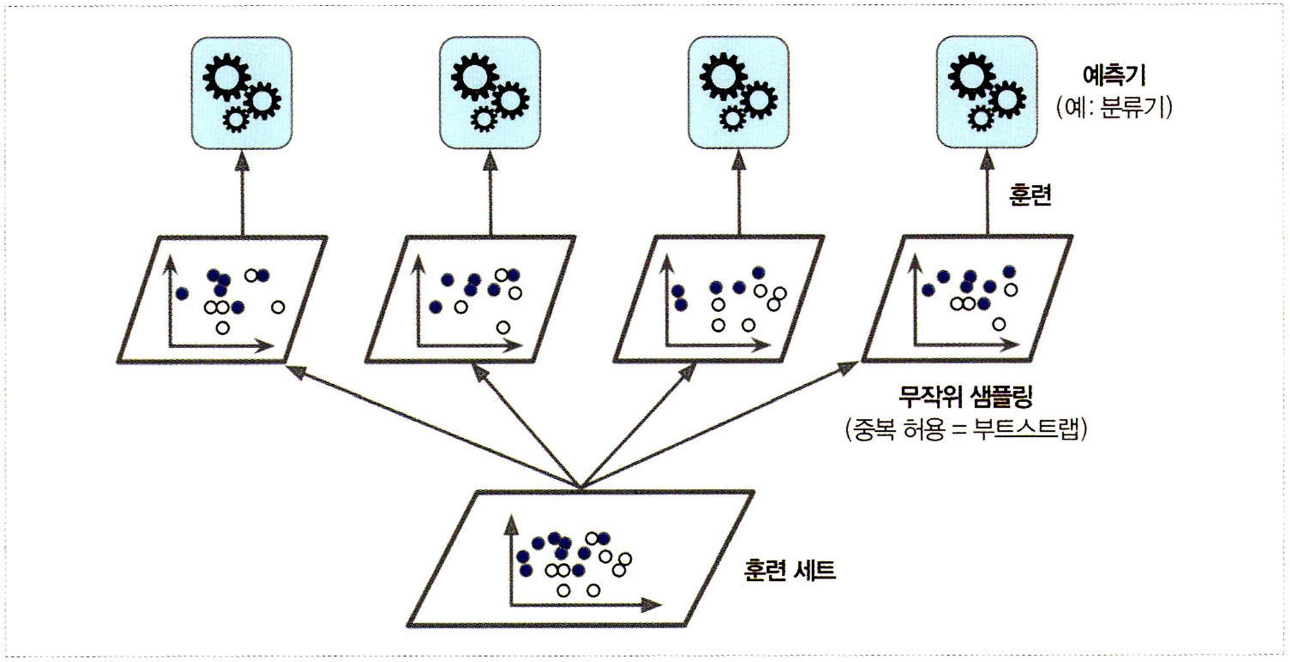

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦. 수집 함수는 전형적으로 분류일 때는 **통계적 최빈값**이고 회귀에 대해서는 평균을 계산함. 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함. 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦.

### 7.2.1 사이킷런의 배깅과 페이스팅

- BaggingClassifier: 사이킷런이 제공, 배깅과 페이스팅을 위해 간편한 API로 구성됨
- 결정 트리 분류기 500개 앙상블 훈련
- 페이스팅을 사용하려면 bootstrap=False로 지정
- n_jobs: 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정함

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=50,
    bootstrap=True,
    n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

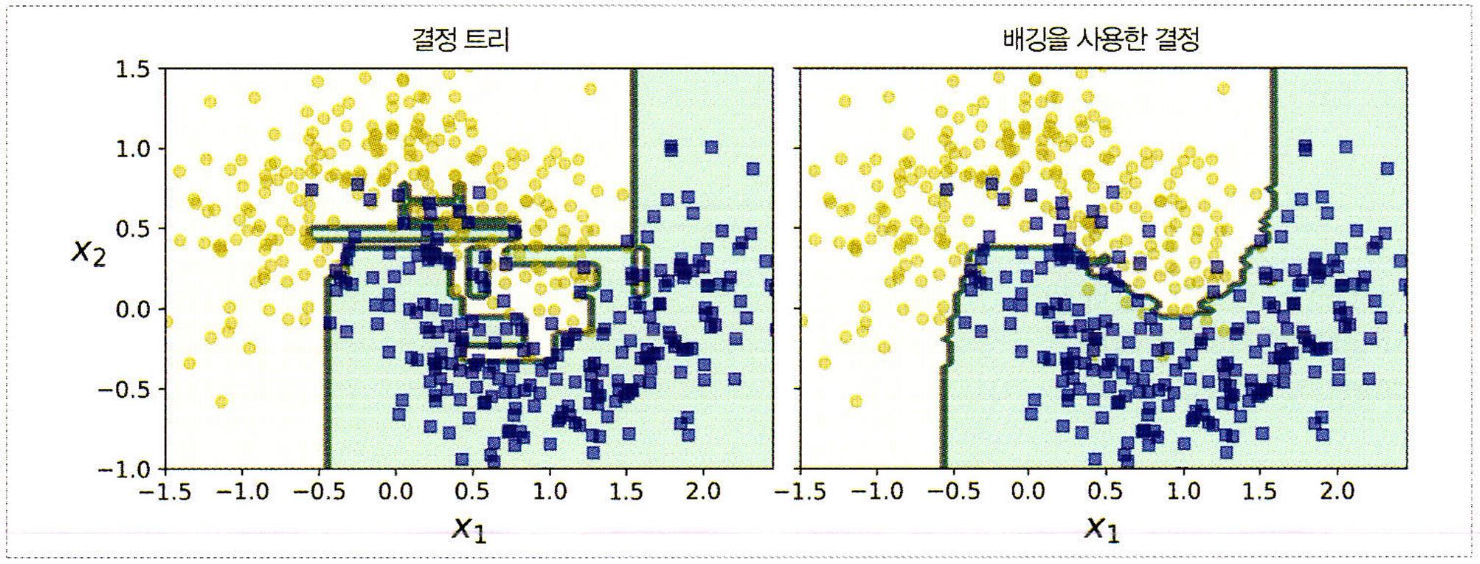

단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교한 것임. 둘 다 moons 데이터셋에 훈련시킴. 두 개를 비교해보면 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘된 것 같음. 앙상블은 비슷한 편향에서 더 작은 분산을 만듦.

### 7.2.2 oob 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음. BaggingClassifier는 기본값으로 중복 허용하여 훈련 세트의 크기만큼인 m개 샘플을 선택함. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 의미. 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag)샘플이라고 부름.

예측기 훈련되는 동안 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음.

사이킷런 BaggingClassifier를 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가 수행.

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

In [7]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [8]:
bag_clf.oob_decision_function_

array([[0.35233161, 0.64766839],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.14857143, 0.85142857],
       [1.        , 0.        ],
       [0.48618785, 0.51381215],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.01092896, 0.98907104],
       [0.12865497, 0.87134503],
       [1.        , 0.        ],
       [0.99470899, 0.00529101],
       [1.        , 0.        ],
       [0.48538012, 0.51461988],
       [0.        , 1.        ],
       [0.89637306, 0.10362694],
       [0.90526316, 0.09473684],
       [0.79329609, 0.20670391],
       [1.        , 0.        ],
       [0.76571429, 0.23428571],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.01081081, 0.98918919],
       [0.98477157, 0.01522843],
       [0.0802139 , 0.9197861 ],
       [0.83783784, 0.16216216],
       [0.99468085, 0.00531915],
       [1.        , 0.        ],
       [0.09150327, 0.90849673],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스

< 특성에 대한 샘플링 >
- max_features
- bootstrap_features

-> 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨

-> 이 기법은 매우 고차원의 데이터셋 다룰 때 유용

- 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

## 7.4 랜덤 포레스트

- 배깅 방법을 적용한 결정 트리의 앙상블
- max_samples: 훈련 세트의 크기로 지정
- BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있음

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성 주입. 이는 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만듦.

In [9]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [10]:
# BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True,
    n_jobs=-1
)

### 7.4.1 엑스트라 트리

- 익스트림 랜덤 트리(엑스트라 트리): 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용함. 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택함.
- 편향이 늘어나지만 대신 분산을 낮춤

### 7.4.2 특성 중요도

랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것임. 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함.

사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화함. 이 값은 feature_importance_ 변수에 저장되어 있음.

In [12]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09502054431034129
sepal width (cm) 0.023428922015042455
petal length (cm) 0.4309279596384118
petal width (cm) 0.45062257403620437
